In [1]:
# Python 3.9.5
# qpsolvers 4.0.0
# SCS 3.2.3
# Mosek 10.1

In [2]:
%matplotlib inline

In [3]:
from grale.all_nb import *
import subprocess
import os
from IPython.display import display, HTML
feedback.setDefaultFeedback("none")

Set 'threads' as default renderer for lensplane and mass density
Set default angular unit in plotting to arcsec
Set feedback style to 'notebook'


In [4]:
cosm = cosmology.Cosmology(0.7, 0.27, 0, 0.73)
cosmology.setDefaultCosmology(cosm)
D = cosm.getAngularDiameterDistance

In [5]:
zd = 0.5
zs1 = 1.2
zs2 = 1.8

In [6]:
nsie = lenses.NSIELens(D(zd), {"velocityDispersion": 1300000, "coreRadius": 1.5*ANGLE_ARCSEC, "ellipticity": 0.8})

pos1, sz1 = V(10,5)*ANGLE_ARCSEC, 1.1*ANGLE_ARCSEC
pos2, sz2 = V(2, -4.5)*ANGLE_ARCSEC, 0.8*ANGLE_ARCSEC

src1 = images.EllipticalSource(pos1, sz1, 0.6, 30)
src2 = images.EllipticalSource(pos2, sz2, 0.4, 110)

li = plotutil.LensInfo(nsie, size=80*ANGLE_ARCSEC, zd=zd)
# This one has more detail, to get the points of the smaller images with more accuracy
liDetail = plotutil.LensInfo(nsie, size=80*ANGLE_ARCSEC, zd=zd, numxy=2047)

In [7]:
critDens1 = lenses.getCriticalDensity(D(zd), D(zs1), D(zd, zs1))
critDens2 = lenses.getCriticalDensity(D(zd), D(zs2), D(zd, zs2))

In [8]:
def getImageData(li, srcShape, zs):
    li.setSourceRedshift(zs)
    ip = li.getImagePlane()
    segs = ip.segment(ip.renderImages([srcShape]))
    
    imgData = images.ImagesData(len(segs))
    for idx, seg in enumerate(segs):
        for pt in seg:
            imgData.addPoint(idx, pt)
    return imgData

imgDat1 = getImageData(liDetail, src1, zs1)
imgDat2 = getImageData(liDetail, src2, zs2)

In [9]:
iws = inversion.InversionWorkSpace(zd, 80*ANGLE_ARCSEC)
iws.addImageDataToList(imgDat1, zs1, "extendedimages")
iws.addImageDataToList(imgDat2, zs2, "extendedimages")

In [10]:
def getMultiMSDLensAndSources(lambda1, lambda2, HW, N, potGradWeight, exactDeflectionTolerance, solver):

    sheet1 = lenses.MassSheetLens(D(zd), {"density": critDens1})
    sheet2 = lenses.MassSheetLens(D(zd), {"density": critDens2})

    msd1 = lenses.CompositeLens(D(zd),[
        { "lens": nsie, "factor": lambda1, "angle": 0, "x": 0, "y": 0 },
        { "lens": sheet1, "factor": (1.0-lambda1), "angle": 0, "x": 0, "y": 0 },
    ])
    msd2 = lenses.CompositeLens(D(zd),[
        { "lens": nsie, "factor": lambda2, "angle": 0, "x": 0, "y": 0 },
        { "lens": sheet2, "factor": (1.0-lambda2), "angle": 0, "x": 0, "y": 0 },
    ])
    
    tr = V(HW,HW)*ANGLE_ARCSEC
    bl = -tr
    _, img1Mask = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat1 ])
    _, img2Mask = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat2 ])
    
    #plt.imshow(img1Mask|img2Mask)
    
    dummyMask = np.zeros((N,N), dtype=bool)
    dummyMask[N//2,N//2] = True
    
    r = lenses.createEquivalentPotentialGridLens(nsie, bl, tr, N, N, [ dummyMask ],
                                             potGradWeight, 1, 0,
                                             pixelEnlargements=0, # Needed to make sure we only start from 1 value
                                             qpsolver=solver,
                                             exactDeflectionConstraints=[
                                                 { "maskRegions": [ img1Mask ], "lens": msd1 },
                                                 { "maskRegions": [ img2Mask ], "lens": msd2 },
                                             ],
                                             exactDeflectionTolerance=exactDeflectionTolerance,
                                             feedbackObject="stdout"
                                            )
    
    newLens = r["philens_equiv"]
    # Rescaling is towards (0,0), which makes the new position easy
    src1New = images.EllipticalSource(pos1*lambda1, sz1*lambda1, 0.6, 30)
    src2New = images.EllipticalSource(pos2*lambda2, sz2*lambda2, 0.4, 110)
    return newLens, src1New, src2New

In [11]:
lambdas = [ 0.9, 0.8]

In [12]:
newLens3, src1New3, src2New3 = getMultiMSDLensAndSources(*lambdas, 50, 256, 0.00002, 0.01*ANGLE_ARCSEC, "scs")

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 28 seconds


In [13]:
liNew3 = plotutil.LensInfo(newLens3, size=80*ANGLE_ARCSEC,zd=zd)

In [14]:
N = 384
tr = V(50,50)*ANGLE_ARCSEC
bl = -tr
dxy = (tr-bl)/V(N,N)

thetas = util.createThetaGrid(bl, tr, N, N)
alpha0x = nsie.getAlphaVector(thetas + V(dxy[0],0)/2.0)[:,:,0]
alpha0y = nsie.getAlphaVector(thetas + V(0,dxy[1])/2.0)[:,:,1]

q = 0.85

alpha1x = alpha0x
alpha1y = q*alpha0y + (D(zs1)/D(zd, zs1)) * thetas[:,:,1] * (1-q)

alpha2x = alpha0x
alpha2y = q*alpha0y + (D(zs2)/D(zd, zs2)) * thetas[:,:,1] * (1-q)

In [15]:
def getScaledEllipseParams(A, ecc, angle, q):
    angle = angle/180*np.pi
    A /= ANGLE_ARCSEC
    B = A*(1-ecc**2)**0.5
    alphas = np.linspace(0, 2*np.pi, 10000)
    x = A*np.cos(alphas)
    y = B*np.sin(alphas)
    xy = np.zeros((2, x.shape[0]), dtype=np.double)
    xy[0,:] = x
    xy[1,:] = y
    rot = np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle), np.cos(angle)]])
    xy2 = rot@xy
    xy3 = xy2.copy()
    xy3[1,:] *= q # scale the y coord
    #plt.plot(xy[0,:], xy[1,:], label="xy")
    #plt.plot(xy2[0,:], xy2[1,:], label="xy2")
    #plt.plot(xy3[0,:], xy3[1,:], label="xy3")
    #plt.gca().set_aspect("equal")
    #plt.legend()
    #plt.show()
    
    # max distance from origin is new A
    distances = np.sum(xy3**2,axis=0)**0.5
    ANew = np.max(distances)
    BNew = np.min(distances)
    idx = np.argmax(distances)
    xm, ym = xy3[:,idx]
    angNew = np.arctan2(ym, xm)

    while angNew < 0:
        angNew += np.pi
    while angNew > np.pi:
        angNew -= np.pi

    angNew *= 180/np.pi
    eccNew = (1-(BNew/ANew)**2)**0.5
    print("ANew", ANew, "eccNew", eccNew, "angNew", angNew)
    return ANew*ANGLE_ARCSEC, eccNew, angNew

In [16]:
newSrc1A, newSrc1Ecc, newSrc1Ang = getScaledEllipseParams(sz1, 0.6, 30, q)
newSrc2A, newSrc2Ecc, newSrc2Ang = getScaledEllipseParams(sz2, 0.4, 110, q)

ANew 1.0729421589942685 eccNew 0.6994010638410001 angNew 17.351225376697872
ANew 0.7464225579061478 eccNew 0.4462893575156905 angNew 164.85650265612867


In [17]:
dummyMask = np.zeros((N,N), dtype=bool)
dummyMask[N//2,N//2] = True

_, imgMask1 = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat1 ], enlargements=5)
_, imgMask2 = util.createThetaGridAndImagesMask(bl, tr, N, N, [ imgDat2 ], enlargements=5)
#plt.imshow(imgMask)

r = lenses.createEquivalentPotentialGridLens(nsie, bl, tr, N, N, [ dummyMask ],
                                             0.00001, 1, 0,
                                             pixelEnlargements=0,
                                             feedbackObject="stdout",
                                             exactDeflectionConstraints=[
                                                 { "maskRegions": [ imgMask1 ],
                                                   "ax": alpha1x, "ay": alpha1y },
                                                 { "maskRegions": [ imgMask2 ],
                                                   "ax": alpha2x, "ay": alpha2y }
                                             ],
                                             exactDeflectionTolerance=0.1*ANGLE_ARCSEC,
                                             qpsolver="scs")

newLens = r["philens_equiv"]

STATUS: Calculating lens potential values
STATUS: Calculating linear constraints
STATUS: Calculating quadratic optimization matrices
STATUS: Solving quadratic programming problem
STATUS: Done, in 97.1 seconds


In [18]:
liNewSpt = plotutil.LensInfo(newLens, size=80*ANGLE_ARCSEC, zd=zd)

In [19]:
newSrc1 = images.EllipticalSource(pos1*V(1,q), newSrc1A, newSrc1Ecc, angle=newSrc1Ang)
newSrc2 = images.EllipticalSource(pos2*V(1,q), newSrc2A, newSrc2Ecc, angle=newSrc2Ang)

In [20]:
def plot2DDensity(li):
    zMax = 10
    
    plotutil.plotDensityContours(li, densityUnit=critDens1, levels=np.arange(0.2, zMax, 0.2), linewidths=0.5, colors="black", linestyles="-")
    plotutil.plotDensityContours(li, densityUnit=critDens1, levels=[1], linewidths=[2], colors="black")
    
    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")

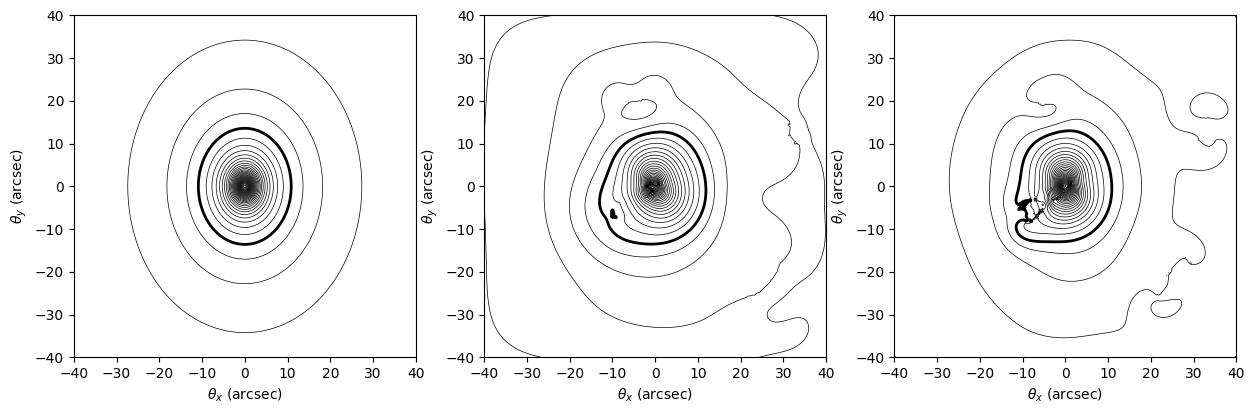

In [21]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plot2DDensity(li)
plt.subplot(1,3,2)
plot2DDensity(liNew3)
plt.subplot(1,3,3)
plot2DDensity(liNewSpt)

In [22]:
def getImagesDataFromPlane(lensInfo, src, zs, asSource=False):
    lensInfo.setSourceRedshift(zs)
    ip = lensInfo.getImagePlane()
    pts = ip.segment(ip.renderImages([src]) if not asSource else ip.renderSources([src]))
    imgDat = images.ImagesData(len(pts))
    for idx in range(len(pts)):
        for pt in pts[idx]:
            imgDat.addPoint(idx, pt)
            
    return imgDat
    
def plotImgPlane(li, src, zs, linestyle, boxImages=False):
    li.setSourceRedshift(zs)
    ip = li.getImagePlane()
    lines = ip.getCriticalLines()
    for l in lines:
        l = np.array(l)/ANGLE_ARCSEC
        plt.plot(l[:,0], l[:,1], ls=linestyle, color="black", lw=1)
        
    imgDat = getImagesDataFromPlane(li, src, zs)
    allPts = list(imgDat.getAllImagePoints())
    pts = np.array([ x["position"] for img in allPts for x in img ])/ANGLE_ARCSEC
    plt.plot(pts[:,0], pts[:,1], 's', ms=0.2, color="black")
    
    if boxImages:
        for img in imgDat.getAllImagePoints():
            pts = np.array([ x["position"] for x in img ])/ANGLE_ARCSEC
            avg = np.mean(pts, axis=0)
            stddev = np.std(pts, axis=0)
            sz = max(stddev[0], stddev[1])
            #print(sz)
            plt.plot([avg[0]], [avg[1]], 's', ms=sz*25, color="black", mfc="none")
        
    plt.gca().set_xlabel(r"$\theta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\theta_y$ (arcsec)")
    plt.gca().set_xlim(-40,40)
    plt.gca().set_ylim(-40,40)
    plt.gca().set_aspect("equal")

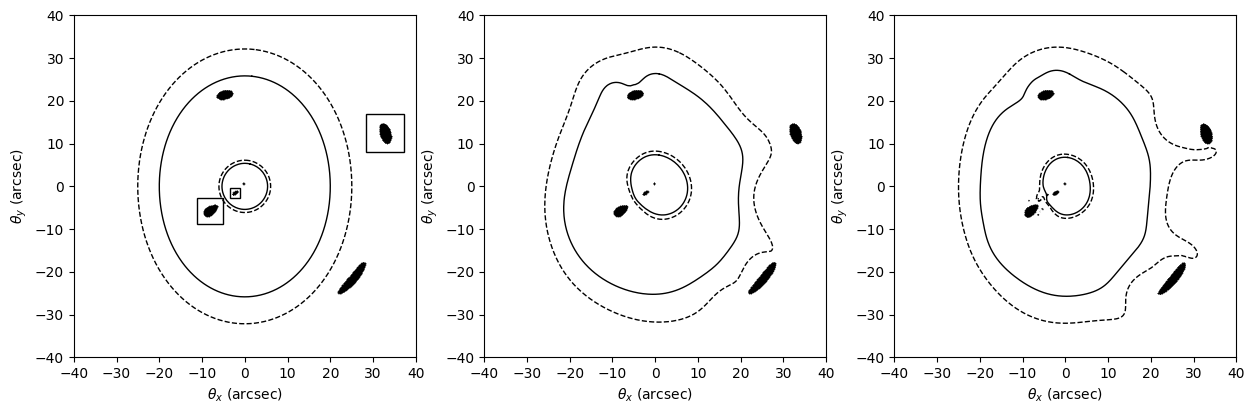

In [23]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plotImgPlane(li, src1, zs1, "-", True)
plotImgPlane(li, src2, zs2, "--")
plt.subplot(1,3,2)
plotImgPlane(liNew3, src1New3, zs1, "-")
plotImgPlane(liNew3, src2New3, zs2, "--")
plt.subplot(1,3,3)
plotImgPlane(liNewSpt, newSrc1, zs1, "-")
plotImgPlane(liNewSpt, newSrc2, zs2, "--")

In [24]:
def plotEllipse(ctr, A, ecc, angle, ls, lw):
    angle = angle/180*np.pi
    B = A*(1-ecc**2)**0.5
    phi = np.linspace(0,2*np.pi,100)
    xy = np.zeros((2, len(phi)))
    xy[0,:] = A*np.cos(phi)
    xy[1,:] = B*np.sin(phi)
    rot = np.array([[np.cos(angle), -np.sin(angle)],
                    [np.sin(angle), np.cos(angle)]])
    xy = (rot@xy).T
    xy += ctr
    plt.plot(xy[:,0], xy[:,1], ls=ls, lw=lw, color="black")

def plotSrcPlane(li, zs, linestyle, src, ellParams1, ellParams2 = None, boxSource = False):
    li.setSourceRedshift(zs)
    ip = li.getImagePlane()
    lines = ip.getCaustics()
    for l in lines:
        l = np.array(l)/ANGLE_ARCSEC
        plt.plot(l[:,0], l[:,1], ls=linestyle, color="black", lw=1)

    imgDat = getImagesDataFromPlane(li, src, zs, True)
    allPts = list(imgDat.getAllImagePoints())
    pts = np.array([ x["position"] for img in allPts for x in img ])/ANGLE_ARCSEC
    plt.plot(pts[:,0], pts[:,1], 'o', ms=1.5, color="gray")

    lw1 = 3 if not ellParams2 else 1
    plotEllipse(*ellParams1, ls="-", lw=lw1)
    if boxSource:
        pos = ellParams1[0]
        plt.plot([pos[0]],[pos[1]], "s", mfc="none", color="black", ms=30)
        
    if ellParams2:
        plotEllipse(*ellParams2, ls="-", lw=3)
    
    plt.gca().set_xlabel(r"$\beta_x$ (arcsec)")
    plt.gca().set_ylabel(r"$\beta_y$ (arcsec)")
    plt.gca().set_xlim(-5,15)
    plt.gca().set_ylim(-7.5,12.5)
    plt.gca().set_aspect("equal")

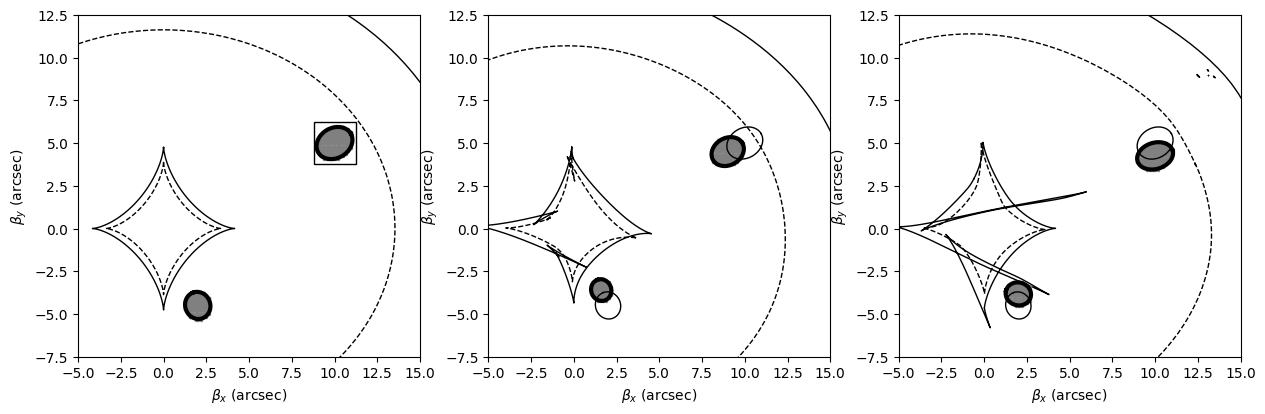

In [25]:
plt.figure(figsize=(15,5))
plt.subplot(1,3,1)
plotSrcPlane(li, zs1, "--", src1, [pos1/ANGLE_ARCSEC, sz1/ANGLE_ARCSEC, 0.6, 30], boxSource=True)
plotSrcPlane(li, zs2, "-", src2, [pos2/ANGLE_ARCSEC, sz2/ANGLE_ARCSEC, 0.4, 110])
plt.subplot(1,3,2)
plotSrcPlane(liNew3, zs1, "--", src1New3, [pos1/ANGLE_ARCSEC, sz1/ANGLE_ARCSEC, 0.6, 30],
                                [pos1*lambdas[0]/ANGLE_ARCSEC, sz1*lambdas[0]/ANGLE_ARCSEC, 0.6, 30])
plotSrcPlane(liNew3, zs2, "-", src2New3, [pos2/ANGLE_ARCSEC, sz2/ANGLE_ARCSEC, 0.4, 110],
                               [pos2*lambdas[1]/ANGLE_ARCSEC, sz2*lambdas[1]/ANGLE_ARCSEC, 0.4, 110])
plt.subplot(1,3,3)
plotSrcPlane(liNewSpt, zs1, "--", newSrc1, [pos1/ANGLE_ARCSEC, sz1/ANGLE_ARCSEC, 0.6, 30],
                                [pos1*V(1,q)/ANGLE_ARCSEC, newSrc1A/ANGLE_ARCSEC, newSrc1Ecc, newSrc1Ang])
plotSrcPlane(liNewSpt, zs2, "-", newSrc2, [pos2/ANGLE_ARCSEC, sz2/ANGLE_ARCSEC, 0.4, 110],
                               [pos2*V(1,q)/ANGLE_ARCSEC, newSrc2A/ANGLE_ARCSEC, newSrc2Ecc, newSrc2Ang])